In [95]:
import flexynesis
import flexynesis 
import os
import torch
import numpy as np
import seaborn as sns
torch.set_num_threads(4)

# Finding Survival Markers in Lower Grade Glioma (LGG) and Glioblastoma Multiforme (GBM)

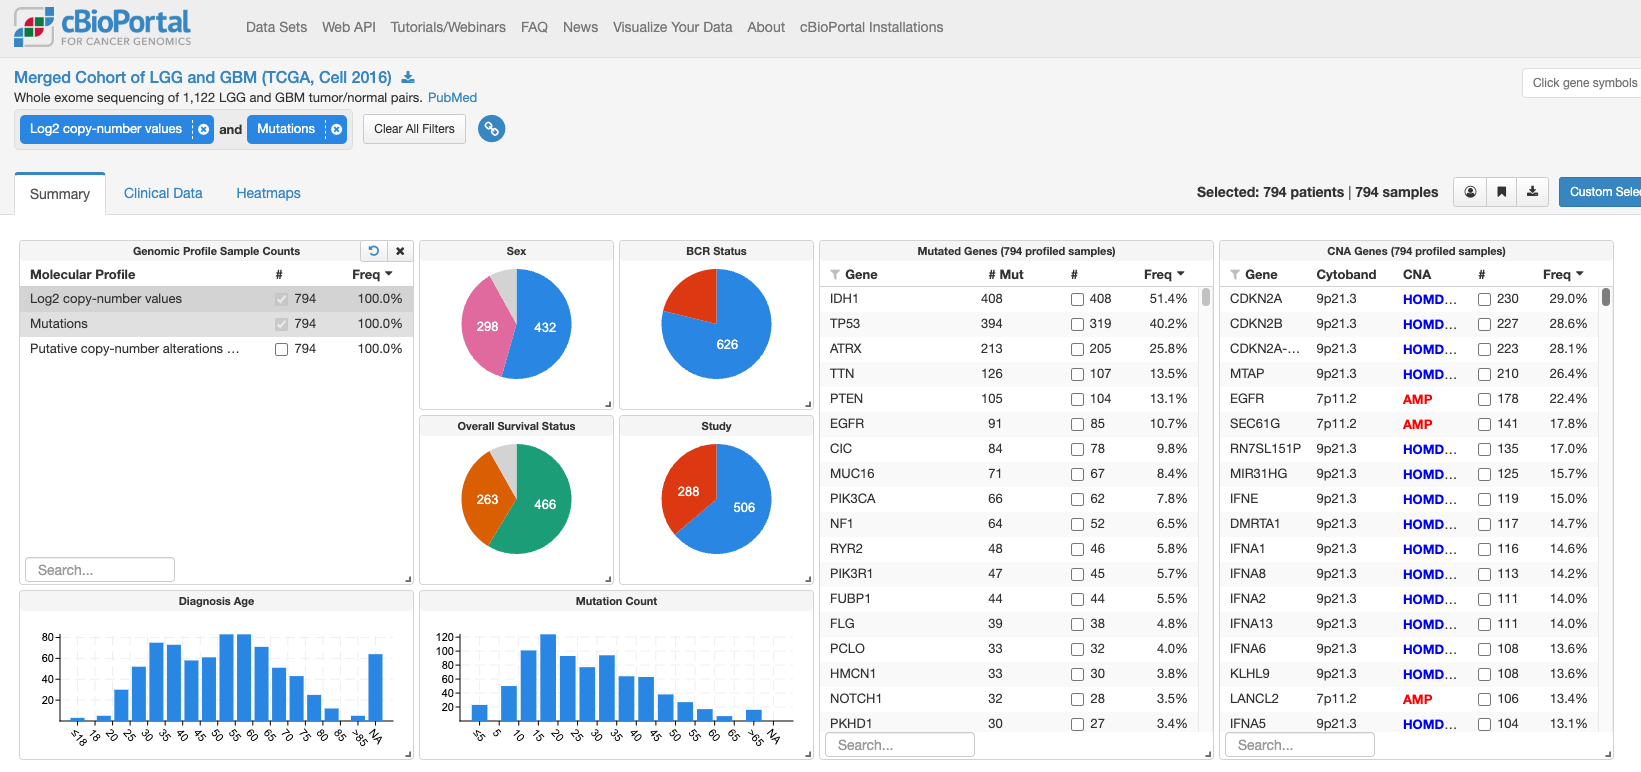

Here, we demonstrate the capabilities of `flexynesis` on a multi-omic dataset of 506 Brain Lower Grade Glioma (LGG) and 288 Glioblastoma Multiforme (GBM) samples with matching mutation and copy number alteration data downloaded from the [cbioportal](https://www.cbioportal.org/study/summary?id=lgggbm_tcga_pub). The data was split into `train` (70% of the samples) and `test` (30% of the samples) data folders. The data files were processed to follow the same nomenclature. 

- `cna.csv` contains "copy number alteration" data
- `mut.csv` contains "mutation" data, which is a binary matrix of genes versus samples. 
- `clin.csv` contains "clinical/sample metatada", which is a table of clinical parameters such as age, sex, disease type, histological diagnosis, and overall survival time and status. 

## Data Download

The data can be downloaded as follows:

In [5]:
if not os.path.exists("lgggbm_tcga_pub_processed"):
    !wget -O lgggbm_tcga_pub_processed.tgz "https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/lgggbm_tcga_pub_processed.tgz" && tar -xzvf lgggbm_tcga_pub_processed.tgz

## Importing Train and Test Datasets

We import train and test datasets including mutations and copy number alterations. We rank genes by Laplacian Scores and pick top 25% of the genes, while removing highly redundant genes with a correlation score threshold of 0.8. By setting `concatenate` to `False`, we will be doing an `intermediate` fusion of omic layers. 

In [6]:
data_importer = flexynesis.DataImporter(path ='lgggbm_tcga_pub_processed', 
                                        data_types = ['mut', 'cna'], log_transform=False, 
                                        concatenate=False, top_percentile=25, min_features=1000, correlation_threshold=0.8)
train_dataset, test_dataset = data_importer.import_data()


[INFO] ================= Importing Data =================
[INFO] Validating data folders...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing /data/local/buyar/arcas/multiomics_integration/datasets/cbioportal/lgggbm_tcga_pub_processed/train/cna.csv...
[INFO] Importing /data/local/buyar/arcas/multiomics_integration/datasets/cbioportal/lgggbm_tcga_pub_processed/train/clin.csv...
[INFO] Importing /data/local/buyar/arcas/multiomics_integration/datasets/cbioportal/lgggbm_tcga_pub_processed/train/mut.csv...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing /data/local/buyar/arcas/multiomics_integration/datasets/cbioportal/lgggbm_tcga_pub_processed/test/cna.csv...
[INFO] Importing /data/local/buyar/arcas/multiomics_integration/datasets/cbioportal/lgggbm_tcga_pub_processed/test/clin.csv...
[INFO] Importing /data/local/buyar/arcas/multiomics_integration/datasets/cbioportal/lgggbm_tcga_pub_processed/test/mut.csv...

[INFO] ----------------- Chec

Filtering redundant features: 100%|██████████| 2306/2306 [00:01<00:00, 2052.55it/s]


[INFO] Implementing feature selection using laplacian score for layer: cna with  24746 features


Filtering redundant features: 100%|██████████| 6186/6186 [00:00<00:00, 52842.67it/s]



[INFO] ----------------- Processing Data (test) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 
[INFO] Number of NA values:  0
[INFO] DataFrame mut - Removed 5627 features.
[INFO] Number of NA values:  0
[INFO] DataFrame cna - Removed 0 features.
[INFO] DataFrame mut - Removed 0 samples (0.00%).
[INFO] DataFrame cna - Removed 0 samples (0.00%).

[INFO] ----------------- Harmonizing Data Sets ----------------- 

[INFO] ----------------- Finished Harmonizing ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 
[INFO] Training Data Stats:  {'feature_count in: mut': 694, 'feature_count in: cna': 6186, 'sample_count': 556}
[INFO] Test Data Stats:  {'feature_count in: mut': 694, 'feature_count in: cna': 6186, 'sample_count': 238}
[INFO] Merging Feature Logs...
[INFO] Data import successful.


## Finding the best model with Bayesian Hyperparameter Optimisation

Now, we are ready to do a model training using hyperparameter optimisation. 
- `model_class`: We pick `DirectPred` (a fully connected network). We could also pick `supervised_vae` (Supervised Variational Auto-encoder with MMD loss), or `MultiTripletNetwork` (a fully connected network with `triplet loss`). 
- `config_name`: We use the default/built-in hyperparameter search space for `DirectPred` class. 
- `surv_event_var` and `surv_time_var`. Survival status (consists of 0s and 1s) and time since last followup. It is important that the `clin.csv` file contains both `OS_MONTHS` and `OS_STATUS` as numerical values.
- `target_variables`: We also want the concurrently train the same network to be able to predict the histological diagnosis. 
- `n_iter`: We do 20 iterations of hyperparameter optimisation. This is a reasonable number of demonstration purposes, but it could be beneficial to increase this value in order to discover even better models. 
- `plot_losses`: We want to visualize how the training progresses. 
- `early_stop_patience`: If a training does not show any signs of improving the performance on the `validation` part of the `train_dataset` for at least 10 epochs, we stop the training. This not only significantly decreases the amount spent on training by avoiding unnecessary continuation of unpromising training runs, but also helps avoid over-fitting the network on the training data. 
- `use_loss_weighting`: The network is trained for multiple variables here, generating different loss values. We want to have a balancing of the impact of each loss type so that the learning is not dominated by a certain target. 

### Define a tuner

In [87]:
tuner = flexynesis.HyperparameterTuning(train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        config_name = "DirectPred",
                                        surv_event_var="OS_STATUS",
                                        surv_time_var="OS_MONTHS",
                                        target_variables = [], 
                                        n_iter=20, 
                                        plot_losses=True, 
                                        early_stop_patience=10,
                                        use_loss_weighting=True)

### Perform Training 

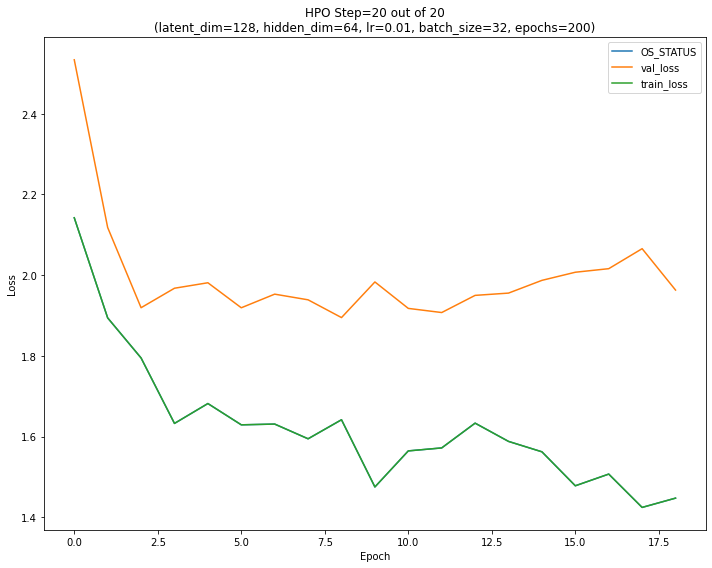

Monitored metric val_loss did not improve in the last 10 records. Best score: 1.895. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         OS_STATUS         │     1.963117760325235     │
│         val_loss          │     1.963117760325235     │
└───────────────────────────┴───────────────────────────┘


Tuning Progress: 100%|██████████| 20/20 [03:56<00:00, 11.81s/it, Iteration=20, Best Loss=1.96]


{'latent_dim': 128,
 'hidden_dim': 64,
 'lr': 0.01,
 'batch_size': 32,
 'epochs': 200}

In [88]:
model, best_params = tuner.perform_tuning()
best_params

## Evaluating the model and visualising the results

In [89]:
flexynesis.evaluate_wrapper(y_pred_dict=model.predict(test_dataset), dataset = test_dataset, 
                            surv_event_var=model.surv_event_var, surv_time_var=model.surv_time_var)

,var,variable_type,metric,value
0,OS_STATUS,numerical,cindex,0.736045


With a quick HPO routine, we achieve a reasonable performance of Harrell's Concordance Index (C-index) of 0.74 on test data. 

### Survival-risk subtypes 

Let's group the samples by predicted survival risk scores into 3 groups and visualize the sample embeddings colored by risk subtypes. 

In [90]:
# get model outputs for survival variable
outputs = model.predict(test_dataset)['OS_STATUS'].flatten() 
risk_scores = np.exp(outputs)
# Define quantile thresholds
quantiles = np.quantile(risk_scores, [0.5])
# Assign groups based on quantiles
groups = np.digitize(risk_scores, quantiles)

In [99]:
# Extract sample embeddings 
E = model.transform(test_dataset)

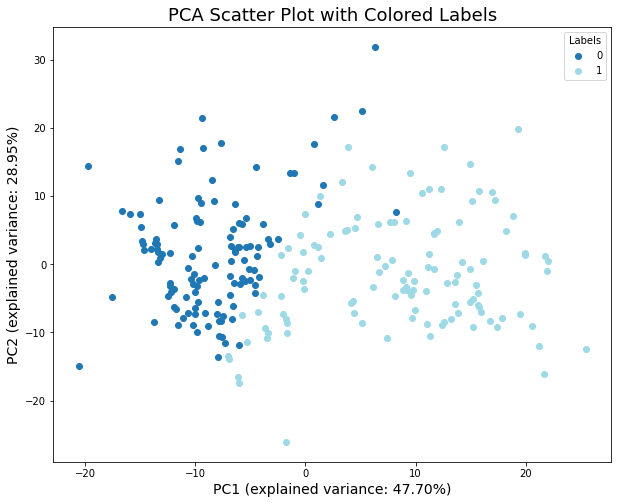

In [100]:
flexynesis.plot_dim_reduced(E, groups)

Let's also see the Kaplan Meier Curves of the risk subtypes

In [101]:
# remove samples with NA values first 
durations = test_dataset.ann['OS_MONTHS']
events = test_dataset.ann['OS_STATUS']
valid_indices = ~torch.isnan(durations) & ~torch.isnan(events)

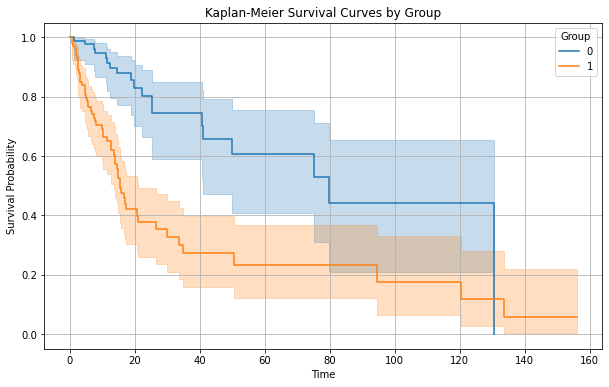

In [102]:
flexynesis.plot_kaplan_meier_curves(durations[valid_indices], events[valid_indices], groups[valid_indices]) 